In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
from keras.layers import Flatten, Dense, Dropout
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import os

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN 
from collections import Counter
import seaborn as sns
import scipy
from numba import cuda 

from sklearn.metrics import confusion_matrix

2023-04-10 05:15:59.276604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 05:16:00.168764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cud

In [2]:
def reset_gpu():
    device = cuda.get_current_device()
    device.reset()

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

In [4]:
tiles_expanded_rv = pd.read_csv(r'Data/Tiles_TRAIN.csv')
tiles_expanded_rv_test = pd.read_csv(r'Data/Tiles_TEST.csv')

In [5]:
# tiles_test_rv = pd.read_csv(r'Data/Tiles_TEST.csv')

Split into training and test

In [6]:
MODEL_TYPE='logistic' # 'linear'

if MODEL_TYPE == 'linear':
    input_x = ['Tile_ID','Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_S','RTTYP_U'] # Removing RTTYP_O
    input_y = ['Collisions_Future']
elif MODEL_TYPE == 'logistic':
    input_x = ['Tile_ID', 'Stop_Signs', 'Paving_historical', 'Bus_stop',
       'Collisions_Historical', 'RTTYP_I', 'RTTYP_M', 'RTTYP_O', 'RTTYP_S',
       'RTTYP_U', '94101', '94102', '94104', '94105', '94107',
       '94108', '94109', '94110', '94111', '94112', '94114', '94115', '94116',
       '94117', '94118', '94121', '94122', '94123', '94124', '94127', '94129',
       '94130', '94131', '94132', '94133', '94134', '94141', '94143', '94158',
       '94188']
    input_y = ['bins_numeric']
    

x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_expanded_rv[input_x], 
                                    tiles_expanded_rv[input_y],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)



In [7]:
tiles_expanded_rv_test_x = tiles_expanded_rv_test[ ['Tile_ID', 'Stop_Signs', 'Paving_historical', 'Bus_stop',
       'Collisions_Historical', 'RTTYP_I', 'RTTYP_M', 'RTTYP_O', 'RTTYP_S',
       'RTTYP_U', '94101', '94102', '94104', '94105', '94107',
       '94108', '94109', '94110', '94111', '94112', '94114', '94115', '94116',
       '94117', '94118', '94121', '94122', '94123', '94124', '94127', '94129',
       '94130', '94131', '94132', '94133', '94134', '94141', '94143', '94158',
       '94188']]

tiles_expanded_rv_test_y = tiles_expanded_rv_test['bins_numeric']

### Oversampling using SMOTE

In [8]:

counter = Counter(y_train['bins_numeric'])
print(counter)
ros = RandomOverSampler(random_state=0,sampling_strategy={0:5297, 2:968, 3:230, 1:230, 6:150, 4:100, 7:100, 5:100,10:100,8:100,9:100})
x_train, y_train = ros.fit_resample(x_train, y_train)
counter_sampled = Counter(y_train['bins_numeric'])
print(counter_sampled)


Counter({0: 5297, 2: 968, 3: 230, 1: 108, 6: 53, 4: 22, 7: 11, 5: 4, 10: 3, 8: 3, 9: 1})
Counter({0: 5297, 2: 968, 3: 230, 1: 230, 6: 150, 7: 100, 10: 100, 4: 100, 5: 100, 8: 100, 9: 100})


In [9]:
class_weight_list = compute_class_weight(class_weight='balanced',classes=y_train['bins_numeric'].unique(), y=y_train['bins_numeric'].to_numpy())

In [10]:
print(class_weight_list)

[0.12828874 2.95454545 0.70200977 6.79545455 2.95454545 4.53030303
 6.79545455 6.79545455 6.79545455 6.79545455 6.79545455]


In [11]:
class_weight={}
unique_classes = y_train['bins_numeric'].unique()
for i in range(11) :
    class_weight[unique_classes[i]] = class_weight_list[i]

In [12]:
class_weight

{0: 0.12828873976693497,
 3: 2.9545454545454546,
 2: 0.7020097670924117,
 7: 6.795454545454546,
 1: 2.9545454545454546,
 6: 4.53030303030303,
 10: 6.795454545454546,
 4: 6.795454545454546,
 5: 6.795454545454546,
 8: 6.795454545454546,
 9: 6.795454545454546}

## Image Pre-Processing

In [13]:
IMAGE_PATH = 'Satellite_Imagery/Satellite_Images_Tiled/' 

In [14]:
 #eda
img = tifffile.imread('Satellite_Imagery/Satellite_Images_Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('Satellite_Imagery/Satellite_Images_Tiled/37.tif')[0:148, 0:188, :]

In [15]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [16]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [17]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    data_mini_test = []
    data_mini_test_final = []
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini_test.append(image)
 
    # stack images and trasnform to array
    images_mini_test = np.stack(data_mini_test)
    
    for id in tiles_expanded_rv_test_x['Tile_ID']:
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini_test_final.append(image)
    
    images_mini_test_final = np.stack(data_mini_test_final)
        
    
    return images_mini, images_mini_test, images_mini_test_final


In [18]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini, images_mini_test, images_mini_test_final = preprocess_data_part1(IMAGE_PATH)

In [19]:
np.shape(images_mini)
np.shape(images_mini_test)

(1676, 148, 188, 4)

Street Data Pre-Processing

In [20]:
x_train

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,1526,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11426,0.0,7.0,0.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13993,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3201,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,13779,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7470,9476,1.0,0.0,0.0,17.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7471,9476,1.0,0.0,0.0,17.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7472,12726,0.0,3.0,5.0,11.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7473,10746,0.0,0.0,4.0,11.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
street = np.asarray(x_train[input_x[1:]]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)


street_test = np.asarray(x_test[input_x[1:]]).astype('float32')
street_mini_test = []
for row in street_test:
    street_mini_test.append([[row]])
street_mini_test = np.stack(street_mini_test)
np.shape(street_mini_test)


(1676, 1, 1, 39)

In [22]:
street_test_final = np.asarray(tiles_expanded_rv_test_x[input_x[1:]]).astype('float32')
street_mini_test_final = []
for row in street_test_final:
    street_mini_test_final.append([[row]])
street_mini_test_final = np.stack(street_mini_test_final)
np.shape(street_mini_test_final)

(2095, 1, 1, 39)

In [23]:
print(street_mini.shape)
print(images_mini.shape)

(7475, 1, 1, 39)
(7475, 148, 188, 4)


In [24]:
input_image_street = np.hstack(
    (street_mini.reshape((7475,39)),
    normalize(images_mini.reshape(7475,-1))
     # images_mini.reshape(8376,148*188*4)
    )
)

In [25]:
print(street_mini_test.shape)
print(images_mini_test.shape)

(1676, 1, 1, 39)
(1676, 148, 188, 4)


In [26]:
input_image_street_test = np.hstack(
    (street_mini_test.reshape((1676,39)),
    # images_mini_test.reshape((2095,148*188*4))
    normalize(images_mini_test.reshape(1676,-1))
    ))

In [27]:
input_image_street_test.shape

(1676, 111335)

In [28]:
print(street_mini_test_final.shape)
print(images_mini_test_final.shape)

(2095, 1, 1, 39)
(2095, 148, 188, 4)


In [29]:
input_image_street_test_final = np.hstack(
    (street_mini_test_final.reshape((2095,39)),
    # images_mini_test.reshape((2095,148*188*4))
    normalize(images_mini_test_final.reshape(2095,-1))
    ))

## LOGISTIC MODEL WITH IMAGES

Model: "logistic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111335)]          0         
                                                                 
 dense (Dense)               (None, 11)                1224696   
                                                                 
Total params: 1,224,696
Trainable params: 1,224,696
Non-trainable params: 0
_________________________________________________________________


2023-04-10 04:15:21.650173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 04:15:21.657316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 04:15:21.657668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 04:15:21.658360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/80


2023-04-10 04:15:27.696903: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f46b647bc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-10 04:15:27.696949: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla M60, Compute Capability 5.2
2023-04-10 04:15:27.702739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-10 04:15:27.869217: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/187 [==============================] - 3s 10ms/step - loss: 0.8121 - accuracy: 0.4843 - val_loss: 2.5794 - val_accuracy: 0.2930
Epoch 2/80
187/187 [==============================] - 1s 8ms/step - loss: 0.7230 - accuracy: 0.5938 - val_loss: 2.2894 - val_accuracy: 0.3893
Epoch 3/80
187/187 [==============================] - 1s 8ms/step - loss: 0.6714 - accuracy: 0.6278 - val_loss: 1.8472 - val_accuracy: 0.4174
Epoch 4/80
187/187 [==============================] - 1s 8ms/step - loss: 0.6334 - accuracy: 0.6699 - val_loss: 1.8074 - val_accuracy: 0.3298
Epoch 5/80
187/187 [==============================] - 1s 8ms/step - loss: 0.5869 - accuracy: 0.6834 - val_loss: 1.5956 - val_accuracy: 0.5017
Epoch 6/80
187/187 [==============================] - 1s 8ms/step - loss: 0.5634 - accuracy: 0.6958 - val_loss: 1.4976 - val_accuracy: 0.4809
Epoch 7/80
187/187 [==============================] - 1s 8ms/step - loss: 0.5330 - accuracy: 0.7120 - val_loss: 1.2005 - val_accuracy: 0.6314
Epoch 8/80
187/1

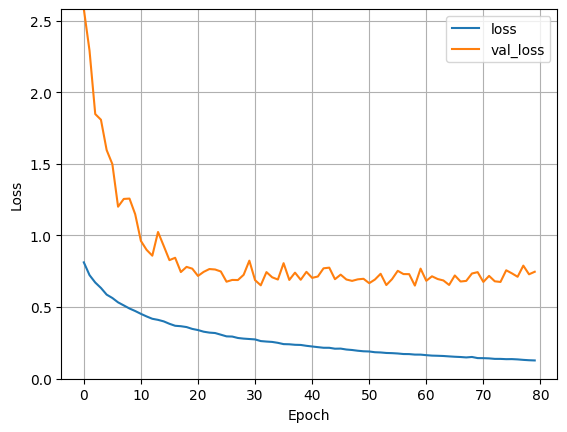

In [33]:
tf.keras.backend.clear_session()
def create_logistic_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111335,))
    outputs = keras.layers.Dense(units = 11, activation = 'softmax')(input)

    log_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="logistic_model")

    log_model.summary()

    log_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
        )
    
    return log_model

logistic_model = create_logistic_model()

history = logistic_model.fit(
    input_image_street,
    np.stack(y_train.to_numpy()),
    epochs=80, 
    validation_split = 0.2,
    class_weight = class_weight
    )

plot_loss(history)

In [32]:
import pdb
def predict_and_vis(model, x_true, y_true):
    predict_result = history.model.predict(x_true)
    predictions = []
    
    length_of_unique_classes = len(y_true['bins_numeric'].unique())
    
    for x in range(len(predict_result)):
        predictions.append(np.argmax(predict_result[x]))
        
    # pdb.set_trace()
    
    print(f"WEIGHTED F1 SCORE: {f1_score(y_true['bins_numeric'].to_numpy(), predictions, average='weighted', sample_weight=None, zero_division='warn')}")
    print(f"F1 SCORE: {f1_score(y_true['bins_numeric'].to_numpy(), predictions, average=None, sample_weight=None, zero_division='warn')}")
    
    cm = confusion_matrix(y_true['bins_numeric'], predictions)
    cm_df = pd.DataFrame(cm,
                     index = [x for x in range(length_of_unique_classes)],
                     columns = [x for x in range(length_of_unique_classes)])
    return cm_df

In [65]:
cm_df = predict_and_vis(history, input_image_street_test, y_test)

53/53 [==============================] - 0s 5ms/step
WEIGHTED F1 SCORE: 0.7658756513207617
F1 SCORE: [0.86703822 0.13333333 0.41881639 0.2300885  0.         0.
 0.30769231 0.         0.        ]


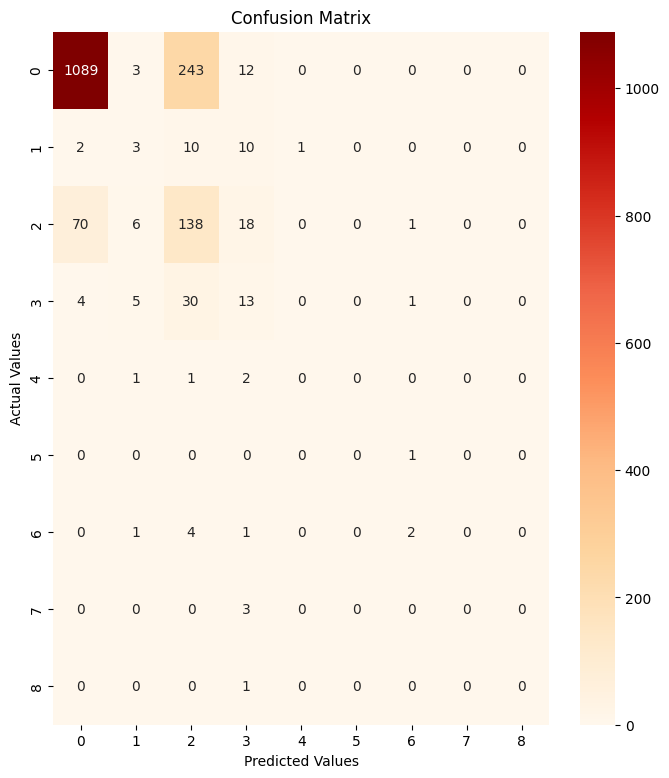

In [66]:
plt.figure(figsize=(8,9))
sns.heatmap(cm_df, annot=True, fmt='.4g',cmap="OrRd")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [67]:
cm_df_normalize = cm_df.div(cm_df.sum(axis=1), axis=0)

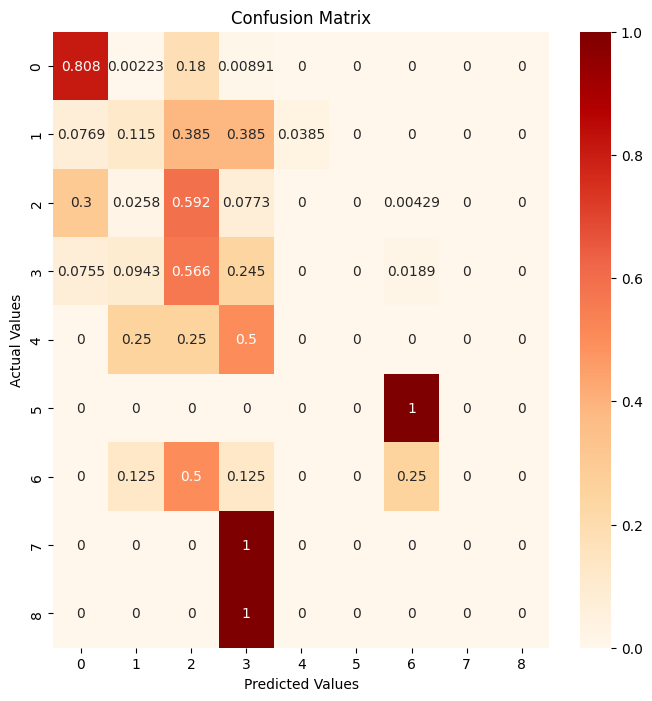

In [68]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_df_normalize, annot=True, fmt='.3g',cmap="OrRd")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [69]:
cm_df = predict_and_vis(history, input_image_street_test_final, tiles_expanded_rv_test)

66/66 [==============================] - 0s 5ms/step
WEIGHTED F1 SCORE: 0.7449462957333384
F1 SCORE: [0.85450955 0.31168831 0.41818182 0.15686275 0.         0.
 0.21052632 0.         0.         0.        ]


In [70]:
cm_df

,0,1,2,3,4,5,6,7,8,9
0,1298,2,321,25,0,0,0,0,0,0
1,3,12,18,9,0,0,1,0,0,0
2,84,9,184,27,0,0,0,0,0,0
3,7,3,49,12,1,0,0,0,0,0
4,0,3,0,4,0,0,3,0,0,0
5,0,1,0,0,1,0,0,0,0,0
6,0,3,3,3,0,0,2,0,0,0
7,0,0,1,1,2,0,0,0,0,0
8,0,1,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,1,0,0,0


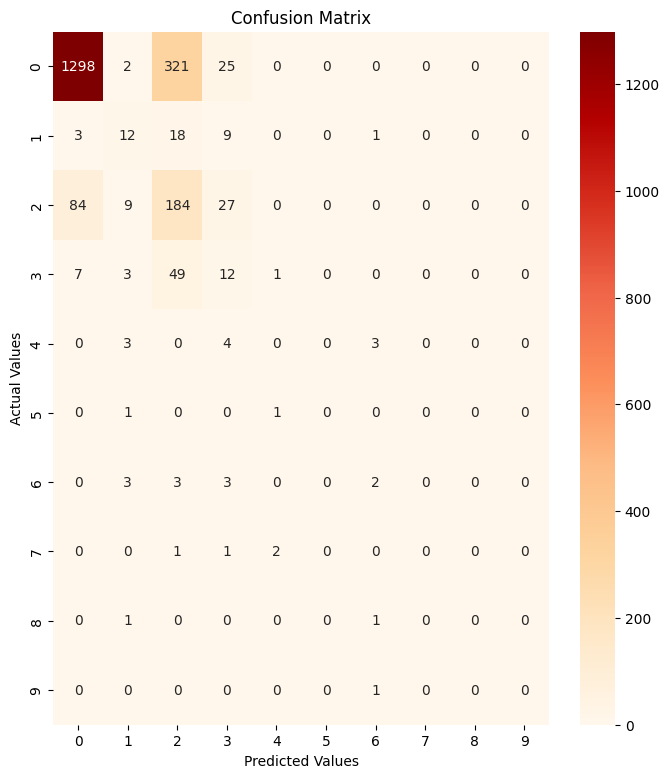

In [71]:
plt.figure(figsize=(8,9))
sns.heatmap(cm_df, annot=True, fmt='.4g',cmap="OrRd")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [72]:
cm_df_normalize = cm_df.div(cm_df.sum(axis=1), axis=0)

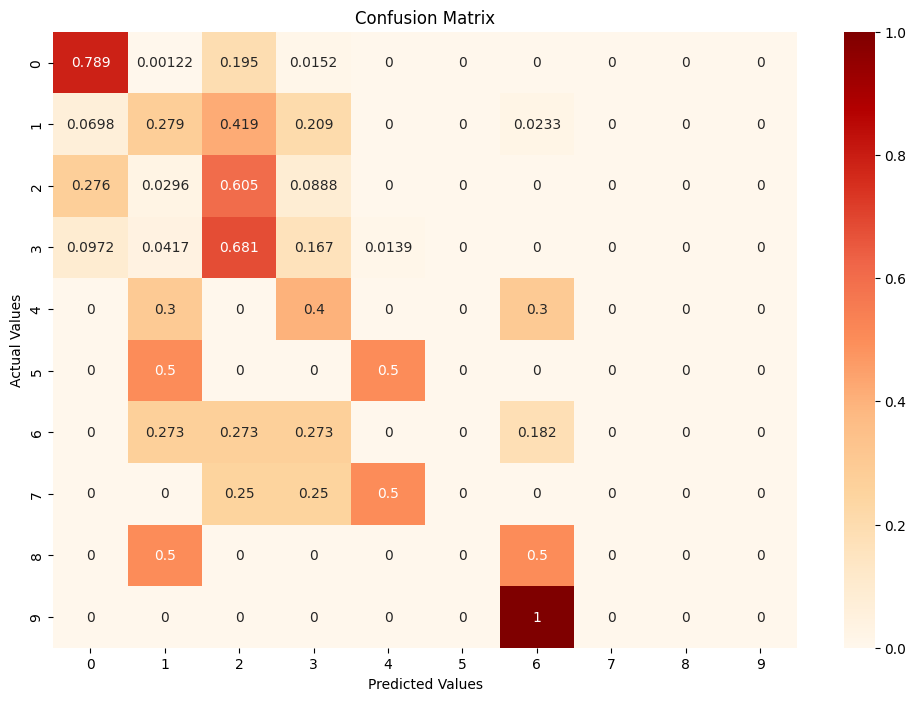

In [73]:
plt.figure(figsize=(12,8))
sns.heatmap(cm_df_normalize, annot=True, fmt='.3g',cmap="OrRd")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Re-training model with validation data in train 

Model: "logistic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111335)]          0         
                                                                 
 dense (Dense)               (None, 11)                1224696   
                                                                 
Total params: 1,224,696
Trainable params: 1,224,696
Non-trainable params: 0
_________________________________________________________________


2023-04-10 05:17:20.406164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 05:17:20.414394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 05:17:20.414790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 05:17:20.415507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/80


2023-04-10 05:17:27.595450: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fdb3e038530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-10 05:17:27.595498: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla M60, Compute Capability 5.2
2023-04-10 05:17:27.601346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-10 05:17:27.769747: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 [==============================] - 3s 6ms/step - loss: 1.8073 - accuracy: 0.4464
Epoch 2/80
234/234 [==============================] - 1s 6ms/step - loss: 1.1658 - accuracy: 0.5951
Epoch 3/80
234/234 [==============================] - 1s 6ms/step - loss: 0.9412 - accuracy: 0.6351
Epoch 4/80
234/234 [==============================] - 1s 6ms/step - loss: 0.8079 - accuracy: 0.6744
Epoch 5/80
234/234 [==============================] - 2s 6ms/step - loss: 0.7118 - accuracy: 0.7064
Epoch 6/80
234/234 [==============================] - 1s 6ms/step - loss: 0.6556 - accuracy: 0.7201
Epoch 7/80
234/234 [==============================] - 1s 6ms/step - loss: 0.6060 - accuracy: 0.7217
Epoch 8/80
234/234 [==============================] - 1s 6ms/step - loss: 0.5647 - accuracy: 0.7334
Epoch 9/80
234/234 [==============================] - 1s 6ms/step - loss: 0.5262 - accuracy: 0.7438
Epoch 10/80
234/234 [==============================] - 1s 6ms/step - loss: 0.4970 - accuracy: 0.7556
Epoch 11/8

KeyError: 'val_loss'

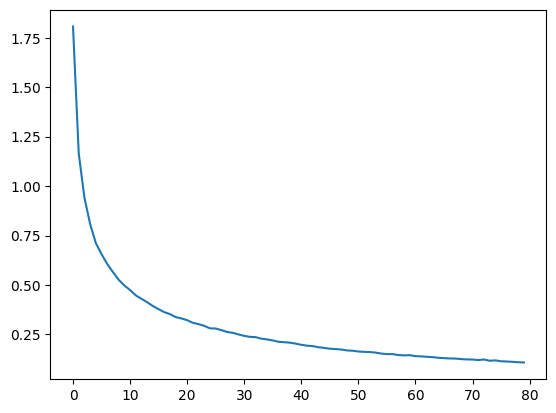

In [30]:
tf.keras.backend.clear_session()
def create_logistic_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111335,))
    outputs = keras.layers.Dense(units = 11, activation = 'softmax')(input)

    log_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="logistic_model")

    log_model.summary()

    log_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
        )
    
    return log_model

logistic_model = create_logistic_model()

history = logistic_model.fit(
    input_image_street,
    np.stack(y_train.to_numpy()),
    epochs=80, 
    class_weight = class_weight
    )

plot_loss(history)

In [33]:
cm_df = predict_and_vis(history, input_image_street_test_final, tiles_expanded_rv_test)

66/66 [==============================] - 0s 5ms/step
WEIGHTED F1 SCORE: 0.7643356957747494
F1 SCORE: [0.87620269 0.23880597 0.43576826 0.19631902 0.11764706 0.
 0.09090909 0.         0.         0.        ]


## Saving the model

In [34]:
history.model.save_weights('./checkpoint_11_bins/logistic_model_10bins_weight')